In [33]:
from pathlib import Path

import numpy as np
import pandas as pd
import patsy
import plotnine as p
import tensorflow as tf
import tensorflow_probability as tfp

%pylab inline
%config InlineBackend.figure_format = 'retina'

tfd = tfp.distributions
tfb = tfp.bijectors

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('zeb2_table.csv', index_col = 0)

In [3]:
data

,cell_id,patient_assignment,tissue_assignment,disease_assignment,celltype,total_count,cell_group,ZEB2
AAACCTGCATGGTAGG-1,1,C1,R,healthy,T,4528.0,T : R : healthy,0.0
AAACGGGAGATAGGAG-1,2,C1,R,healthy,T,3120.0,T : R : healthy,0.0
AACACGTGTGTGCCTG-1,3,C1,R,healthy,T,5019.0,T : R : healthy,0.0
AACCGCGGTTCAGACT-1,4,C1,R,healthy,T,3733.0,T : R : healthy,0.0
AACCGCGTCTCGCATC-1,5,C1,R,healthy,T,2605.0,T : R : healthy,0.0
...,...,...,...,...,...,...,...,...
AAAGATGAGAATGTGT-30,68623,C9,PBMC,healthy,T,1924.0,T : PBMC : healthy,0.0
CGACTTCGTGACTACT-30,68624,C9,PBMC,healthy,T,4409.0,T : PBMC : healthy,0.0
GTATTCTCAAGCCATT-30,68625,C9,PBMC,healthy,T,2512.0,T : PBMC : healthy,0.0
TGCCCATAGTTGCAGG-30,68626,C9,PBMC,healthy,T,1372.0,T : PBMC : healthy,0.0


In [4]:
data['cell_group_cat'] = data['cell_group'].pipe(pd.Categorical)
data['patient_assignment_cat'] = data['patient_assignment'].pipe(pd.Categorical)

In [5]:
def make_joint_distribution_coroutine(fixed_effects, random_effects, n_fe, n_re, offset):
    def model():
        re_scale = yield tfd.HalfNormal(scale = 1., name = 're_scale_prior')
        re_prior = yield tfd.Normal(loc = tf.zeros(n_re), scale = re_scale, name = 're_prior')
        
        fe_weight = yield tfd.Normal(loc = tf.zeros(n_fe), scale = 1., name = 'fe_weight')
        
        random_effect = tf.gather(re_prior, random_effects, axis = -1)
        fixed_effect = tf.gather(fe_weight, fixed_effects, axis = -1)
        
        linear_response = fixed_effect + random_effect
        
        yield tfd.Poisson(log_rate = linear_response + offset, name = 'likelihood')
        
    return tfd.JointDistributionCoroutineAutoBatched(model)

joint = make_joint_distribution_coroutine(
    data['cell_group_cat'].cat.codes.values.astype(np.int64),
    data['patient_assignment_cat'].cat.codes.values.astype(np.int64),
    data['cell_group_cat'].cat.categories.shape[0],
    data['patient_assignment_cat'].cat.categories.shape[0],
    data['total_count'].pipe(np.log).values
)

def target_log_prob_fn(*args):
    return joint.log_prob(*args, likelihood = data['ZEB2'].values)

In [6]:
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
  event_shape=joint.event_shape_tensor()[:-1],
  constraining_bijectors = [tfb.Softplus(), None, None]
)

In [7]:
optimizer = tf.optimizers.Adam(learning_rate = 1e-2)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn, 
    surrogate_posterior,
    optimizer = optimizer,
    num_steps = 10000,
    sample_size = 2
)

(
    re_scale_prior_,
    re_weight_,
    fe_weight_,
), _ = surrogate_posterior.sample_distributions()

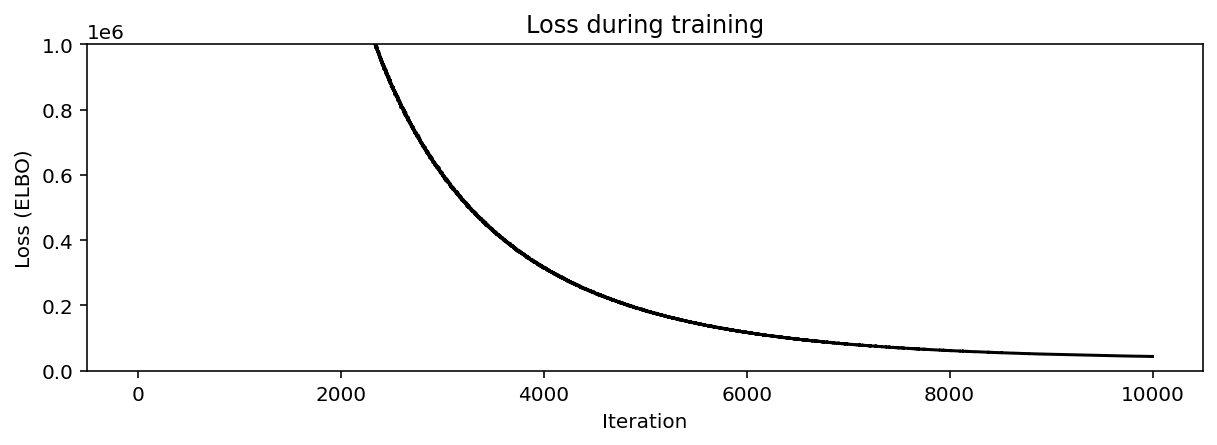

In [8]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(losses, 'k-')
ax.set(
    xlabel="Iteration",
    ylabel="Loss (ELBO)",
    title="Loss during training",
    ylim=(0, 1e6)
);


In [9]:
fixed_effect_posteriors = pd.DataFrame({
    'cell_group': data['cell_group_cat'].cat.categories,
    'mean': fe_weight_.mean(),
    'std': fe_weight_.stddev()
})

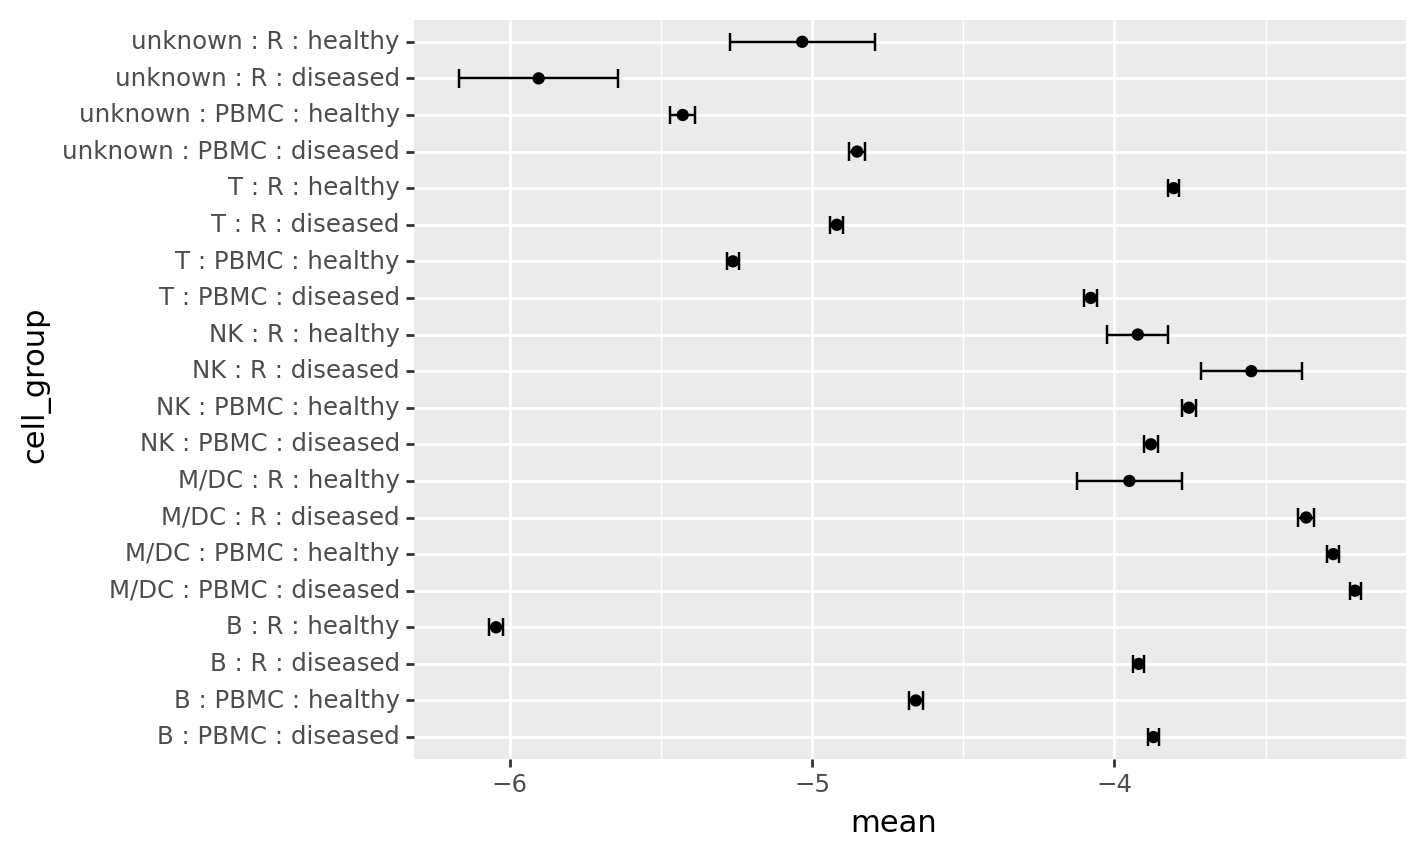

<ggplot: (-9223371864382998420)>

In [10]:
(
    p.ggplot(p.aes(y = 'cell_group', x = 'mean'), fixed_effect_posteriors)
    + p.geom_point()
    + p.geom_errorbarh(p.aes(xmin = 'mean - 2 * std', xmax = 'mean + 2 * std'))
)

In [11]:
random_effect_posteriors = pd.DataFrame({
    'patient_assignment': data['patient_assignment_cat'].cat.categories,
    'mean': re_weight_.mean(),
    'std': re_weight_.stddev()
})

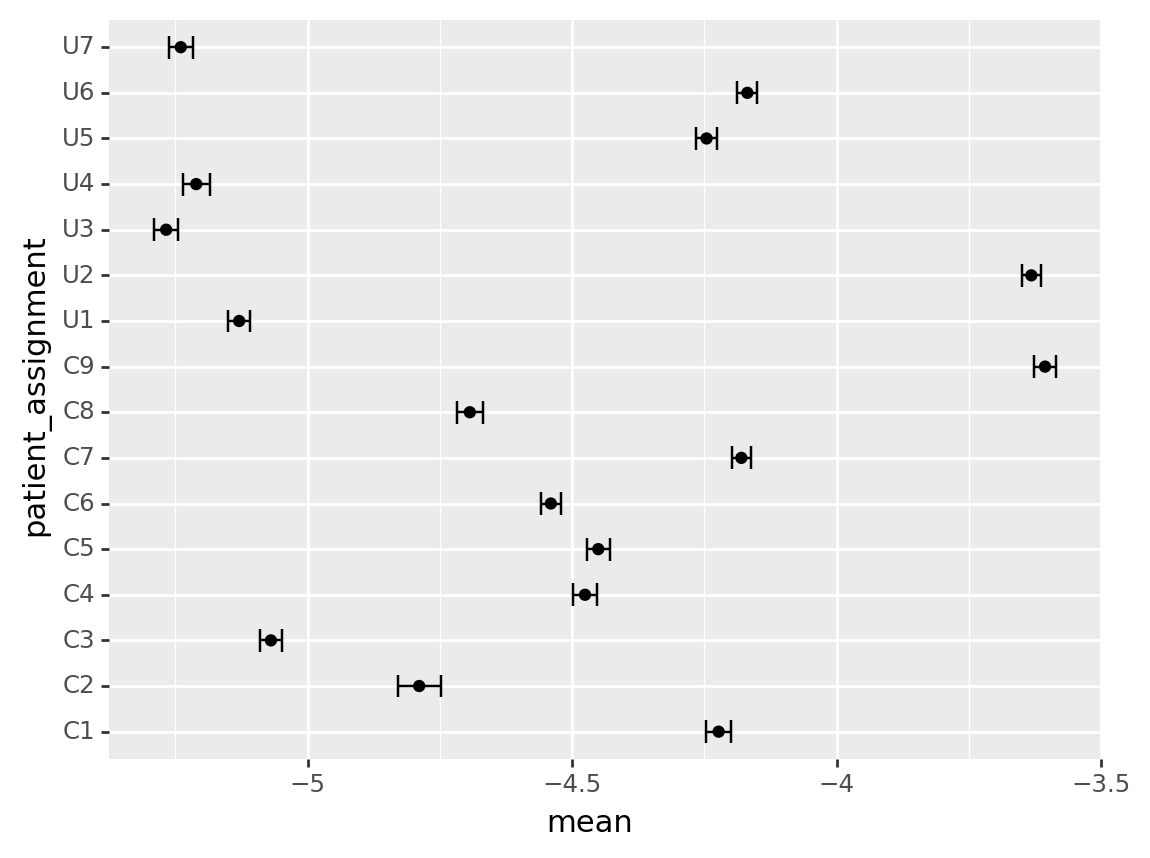

<ggplot: (-9223371864383120548)>

In [12]:
(
    p.ggplot(p.aes(y = 'patient_assignment', x = 'mean'), random_effect_posteriors)
    + p.geom_point()
    + p.geom_errorbarh(p.aes(xmin = 'mean - 2 * std', xmax = 'mean + 2 * std'))
)

In [25]:
re_scale = tf.reduce_mean(re_scale_prior_.sample(10000)).numpy()

In [26]:
re_scale

3.572364

In [39]:
re_scale_df = pd.DataFrame({'Groups': ['patient_assignment'], 'Name': ['(Intercept)'], 'Std.Dev.': re_scale})

In [40]:
output_dir = Path('tfp/run1')
output_dir.mkdir(parents=True, exist_ok=True)

fixed_effect_posteriors.to_csv(output_dir / 'fixed_effects.csv')
random_effect_posteriors.to_csv(output_dir / 'random_effects.csv')
re_scale_df.to_csv(output_dir / 'varcorr.csv')

In [46]:
for i in range(2, 11):
    print(i)
    surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
      event_shape=joint.event_shape_tensor()[:-1],
      constraining_bijectors = [tfb.Softplus(), None, None]
    )
    
    optimizer = tf.optimizers.Adam(learning_rate = 1e-2)

    losses = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn, 
        surrogate_posterior,
        optimizer = optimizer,
        num_steps = 10000,
        sample_size = 2
    )

    (
        re_scale_prior_,
        re_weight_,
        fe_weight_,
    ), _ = surrogate_posterior.sample_distributions()
    
    fixed_effect_posteriors = pd.DataFrame({
        'cell_group': data['cell_group_cat'].cat.categories,
        'mean': fe_weight_.mean(),
        'std': fe_weight_.stddev()
    })
    
    random_effect_posteriors = pd.DataFrame({
        'patient_assignment': data['patient_assignment_cat'].cat.categories,
        'mean': re_weight_.mean(),
        'std': re_weight_.stddev()
    })
    
    re_scale = tf.reduce_mean(re_scale_prior_.sample(10000)).numpy()
    
    re_scale_df = pd.DataFrame({'Groups': ['patient_assignment'], 'Name': ['(Intercept)'], 'Std.Dev.': re_scale})
    
    output_dir = Path(f'tfp/run{i}')
    output_dir.mkdir(parents=True, exist_ok=True)

    fixed_effect_posteriors.to_csv(output_dir / 'fixed_effects.csv')
    random_effect_posteriors.to_csv(output_dir / 'random_effects.csv')
    re_scale_df.to_csv(output_dir / 'varcorr.csv')

2
3
4
5
6
7
8
9
10
